I used Joel Grus' code for image processing (2013). 

In [1]:
from PIL import Image
import PIL.ImageOps
from glob import glob
from random import shuffle, seed
import numpy as np
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
# this is the size of all the Target.com images
STANDARD_SIZE = (138,138)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

    
def img_to_array(filename):
    """
    Takes a filename and turns it into a 1D numpy array of RGB pixels
    """
    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s) #reshaping to long row representation
    return -img_wide[0]

#Obtaining all filenames
male_files = glob('./Male/*') 
female_files = glob('./Female/*')

process_file = img_to_array

#Adding data to raw_data list
raw_data = []
for filename in male_files:
    raw_data.append((process_file(filename),'male',filename))
for filename in female_files:
    raw_data.append((process_file(filename),'female',filename))

# pull out the features and the labels
data = np.array([cd for (cd,_y,f) in raw_data])
labels = np.array([_y for (cd,_y,f) in raw_data])



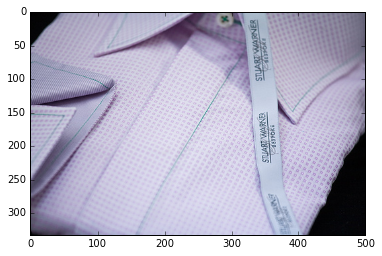

In [2]:
#Visualizing an example of an image
img = Image.open(male_files[0])
imgplot = plt.imshow(img)

In [3]:
#Split data into 80% training data, 20% test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Building the Support Vector Machine Classifier

In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, verbose=True)
clf.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=True, warm_start=False)

I tried a logistic classifier. It achieves 100% accuracy on the training set and only 62.4% accuracy on the test set. I checked the class balance of the data set and the logistic classifier performs a bit better than simply guessing the majority class.

In [42]:
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

1.0
0.624254473161


In [43]:
print float(np.sum(y_test == 'male'))/len(y_test)
print float(np.sum(y_test == 'female'))/len(y_test)

0.477137176938
0.522862823062


I tried a different classifier to see if performance could be better. The support vector machine achieves 100% accuracy on the training set and only 62.2% on the test set. This is because there are fewer data points than dimensions (which is the length of the row representation). Therefore, it is always possible to find a hyperplane that is able to separate the data points. I suspect the same principle applies for the logistic classifier as above where there are more pixel dimensions than there are data points. Therefore, we are severely overfitting the data, as seen by the huge drop in accuracy in the test set. 

In [44]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, verbose=True)
clf.fit(X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=True)

In [45]:
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

1.0
0.62226640159


# Building the Support Vector Machine Classifier using PCA-reduced Representation

I reduced the data to 1000 dimensions and train the SVM using this reduced representation. On this reduced representation, the support vector machine achieves 97.5% accuracy on the training set and 61.6% on the test set. Because there are fewer dimensions (1000) than there are data points, the number of points are no longer linearly separable and thus we see a non-zero error rate in the training set. Interesting, the error rate on the test set has not substantially increased, indicating that reducing the number of dimensions by 50-fold has not substantially thrown away information. This makes sense because many pixels in the image are correlated, allowing for information compression.

In [8]:
# find the principal components
from sklearn.decomposition import PCA
N_COMPONENTS = 1000
pca = PCA(n_components=N_COMPONENTS)
PCA_train = pca.fit_transform(X_train)
clf = LinearSVC(random_state=0, verbose=True)
clf.fit(PCA_train, y_train)



[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=True)

In [9]:
print clf.score(PCA_train,y_train)
# print clf.score(X_test,y_test)

0.975111996018


In [10]:
PCA_test = pca.transform(X_test)
print clf.score(PCA_test,y_test)

0.616302186879


# Exploring the PCA-reduced Representation

As an exercise, I tried visualizing the eigen-clothing, so to speak. These are the 15 directions of maximal variance of the entire data set. These eigen-clothing images reveal that the direction of maximal variance is the direction where there is a large black blob in the center. This makes sense because the focal point of these images are the clothing which are centered, and the borders don't have much going on. The next directions of maximal variance explain the top pixels, bottom pixels, central pixels, left pixels, red and blue pixels... 

In [11]:
n_col = 5
n_row = 10
image_shape = (138,138,3)
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

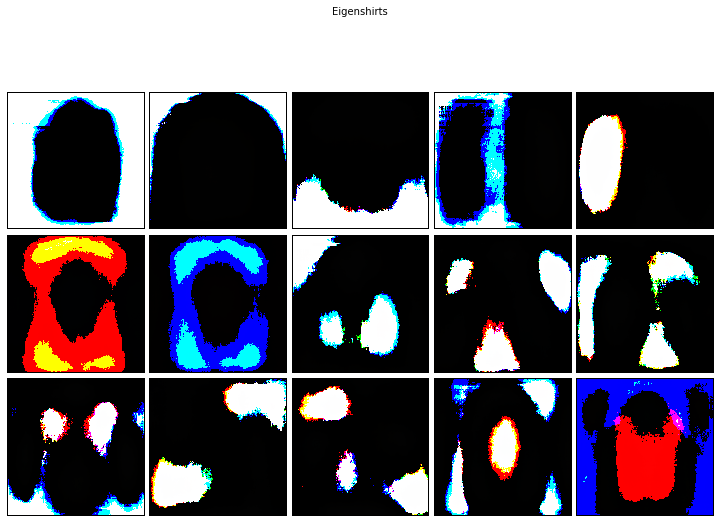

In [13]:
components_ = pca.components_
plot_gallery("Eigenshirts",
                 components_[:15])

I tried reconstructing the images from their reduced representation using inverse_transform. Unfortunately, the reconstruction of the image looks like random noise, nothing like the actual image. This is because there are very precise correlations among nearby pixels in the original image (where one pixel is likely to be exactly identical to its neighbors). It seems that this precise correlation is lost in the PCA reconstruction, where nearby pixels are similar but not exactly equal. 

In [82]:
print pca.inverse_transform(PCA_train[0])

[   1.84184707  101.13233132  145.53766326 ...,  161.22491991   45.73049046
   20.06084054]


In [85]:
image_shape1 = (3,138,138)

In [28]:
print X_train[30][:100]

[ -34  -34  -34  -18  -18  -18  -19  -19  -19  -18  -18  -18  -18  -18  -18
  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18
  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18
  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18  -18
  -18  -18  -18  -18  -18  -18  -18  -18  -18  -19  -19  -21 -164 -181 -189
 -153 -175 -188 -154 -171 -181 -153 -171 -183 -153 -171 -185 -152 -168 -183
 -152 -168 -183 -154 -168 -179 -153 -170 -178 -152]


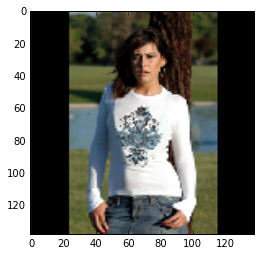

In [26]:
plt.imshow(X_train[30].reshape(image_shape))

In [46]:
proj = pca.inverse_transform(PCA_train[30])
print proj[:100]


[ -3.44919955e+01  -2.72495148e+01  -1.84171467e+01  -3.91057924e+01
  -3.28392021e+01  -2.23070978e+01  -3.63904006e+01  -3.24790985e+01
  -2.12811058e+01  -3.51791789e+01  -3.44767204e+01  -2.28400926e+01
  -3.72867939e+01  -3.42215554e+01  -2.69149813e+01  -2.90300133e+01
  -2.69528462e+01  -2.65852141e+01  -1.25709521e+01  -1.46873929e+01
  -1.18555776e+01  -1.27819862e+01  -1.37493595e+01  -7.57384407e+00
  -1.21991563e+01  -1.25553199e+01  -5.12508091e+00  -2.60200394e+01
  -2.40444657e+01  -1.51155428e+01  -3.15043492e+01  -2.56143212e+01
  -1.88531071e+01  -1.92621021e+01  -2.02989857e+01  -1.22209733e+01
  -4.43871702e+00  -6.92917491e+00  -1.28329639e-01  -1.74157875e+01
  -1.63645140e+01  -7.24425000e+00  -2.25398310e+01  -2.19356841e+01
  -1.33212520e+01  -2.30608106e+01  -2.37538966e+01  -1.80800601e+01
  -4.00567980e+01  -3.25882310e+01  -2.36987960e+01  -3.72730494e+01
  -3.31683404e+01  -2.42944759e+01  -3.51833067e+01  -3.77428433e+01
  -2.71946361e+01  -3.43092338e+01

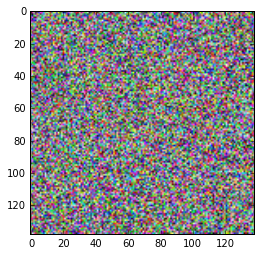

In [47]:
plt.imshow(proj.reshape(image_shape))

# Building the Support Vector Machine Classifier using LDA-reduced Representation

I performed a linear discriminant analysis of the data. The LDA documentation stated that the maximal number of components that I can project onto using LDA is n_classes - 1. Since this is a binary classification problem, this is 1. Therefore, the LDA projects the 57,132 dimensional array into a 1-dimensional array that is best for classification. The SVM trained using the LDA-reduced representation of the data obtains 92.6% accuracy on the training set and 61.6% accuracy on the test set. Even though the accuracy in the training set is less than the PCA-reduced and the full data, it is still impressive that 1-dimension captures enough class-information for the SVC to get 92.6% accuracy on the training set and identical accuracy on the test set to PCA-reduced data (containing 1000 dimensions). 

If our purpose is classifying I would recommend using the SVC that uses the LDA-reduced representation. This is a supervised method that takes into account the fact that our final goal is to perform classification. This method gives us only one single number, and thus achieves a great deal of information compression. Furthermore, there is so much information lost about the actual image that there is practically no way to reconstruct the 57,132-dimensional image from this 1-point summary. This avoids the previous problem of having to interpret the PCA-reconstruction. The PCA reconstruction is very different from our own visual system's decomposition of the image. The SVC using LDA-reduced representation also avoids the problem present in the full-data SVC: that there are more dimensions than images, allowing for a separating hyperplane to be found regardless of the actual data content. One problem that we see in all data representations is overfitting. The training error is much greater than the test error.

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=False, n_components=200)
LDA_train = lda.fit_transform(X_train, y_train)
clf = LinearSVC(random_state=0, verbose=True)
clf.fit(LDA_train, y_train)

/Users/alng/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=True)

In [32]:
print LDA_train.shape

(2009, 1)


We can see that negative values are more likely to be classified "female", and positive values are more likely to be classified "male."

In [34]:
for i in range(100):
    print LDA_train[i], y_train[i]
    

[-2.28257026] female
[ 1.77224157] female
[ 1.70073748] male
[-2.38329688] female
[-2.01573095] female
[ 1.72265855] male
[-1.19623492] female
[ 0.95128944] male
[ 1.18878631] male
[-1.66931241] female
[ 1.39705225] male
[ 1.89479241] male
[-1.7876908] female
[ 0.27499886] male
[ 2.37324149] male
[ 0.70879564] male
[ 0.76044497] male
[ 1.71406276] male
[-1.1205157] female
[ 1.34813025] male
[-1.65839973] female
[ 1.90018642] male
[ 0.68670927] female
[ 1.98219181] male
[ 0.57879368] male
[ 0.7204479] male
[-2.1722595] female
[-2.25682975] female
[-1.15220674] female
[ 0.62294487] male
[-2.10926959] female
[ 1.48324731] male
[ 0.67315657] male
[ 1.6505682] male
[-1.5303244] female
[-1.62593336] female
[ 1.75586181] male
[ 0.61015191] male
[-1.08132177] female
[-1.64675752] female
[-0.9257105] female
[ 1.67658772] male
[-1.70038043] female
[-1.06701788] female
[-1.94435788] female
[ 1.35248954] male
[-2.30526838] female
[-1.7072242] female
[-1.09228596] female
[ 1.30662369] male
[-1.4796

In [35]:
print clf.score(LDA_train,y_train)
# print clf.score(X_test,y_test)

0.926331508213


In [36]:
LDA_test = lda.transform(X_test)
# X_test.shape
# LDA_test
print clf.score(LDA_test,y_test)

0.616302186879


# References 


Grus, J. (2013). _T-Shirts, Feminism, Parenting, and Data Science_. Retrieved  October 15, from https://github.com/joelgrus/shirts/blob/master/visuals.py